# ***MTA***

Data Collection: Collect real-time bus data in New York City for over 24 hours

The chosen bus route is M4, M104, and M5

In [ ]:
import time
import pandas as pd
import requests
import json

api_key = 'eb3a75fd-2b76-4bd8-948d-003cecfd503b'
line_ref = ['MTA%20NYCT_M4', 'MTA%20NYCT_M104', 'MTA%20NYCT_M5']
data = []

start_time = time.time()
end_time = start_time +14400 #time

while time.time() < end_time:
    for line in line_ref:
        url = f'http://bustime.mta.info/api/siri/vehicle-monitoring.json?key={api_key}&VehicleMonitoringDetailLevel=calls&LineRef={line}'
        response = requests.get(url)

        if response.status_code == 200:
            info = response.json()
            response_timestamp = info['Siri']['ServiceDelivery']['ResponseTimestamp']
            vehicle_activity = info['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0].get('VehicleActivity', [])

            for vehicle in vehicle_activity:
                data.append({
                    "LineRef": line,
                    "ResponseTimestamp": response_timestamp,
                    "VehicleRef": vehicle['MonitoredVehicleJourney']['VehicleRef'],
                    "Latitude": vehicle['MonitoredVehicleJourney']['VehicleLocation']['Latitude'],
                    "Longitude": vehicle['MonitoredVehicleJourney']['VehicleLocation']['Longitude'],
                    "DestinationName": vehicle['MonitoredVehicleJourney']['DestinationName'],
                    "OriginRef": vehicle['MonitoredVehicleJourney']['OriginRef']
                })

    time.sleep(15)

df = pd.DataFrame(data)

Bus Velocity Calculation: For each bus in all chosen bus routes, calculate its velocity for each recorded time.

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate haversine distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

df=df.drop_duplicates(subset=['ResponseTimestamp','VehicleRef'])
df['ResponseTimestamp'] = pd.to_datetime(df['ResponseTimestamp'])

df.sort_values(by=['VehicleRef', 'ResponseTimestamp'], inplace=True)
df['lat_diff'] = df.groupby('VehicleRef')['Latitude'].diff()
df['lon_diff'] = df.groupby('VehicleRef')['Longitude'].diff()
df['time_diff'] = df.groupby('VehicleRef')['ResponseTimestamp'].diff().dt.total_seconds() / 3600 #in hours
df['distance_km'] = df.apply(lambda x: haversine(x['Latitude'] - x['lat_diff'], x['Longitude'] - x['lon_diff'], x['Latitude'], x['Longitude']) if not pd.isna(x['lat_diff']) else np.nan, axis=1)

df['velocity_kmh'] = df['distance_km'] / df['time_diff']
df['velocity_kmh'] = df['velocity_kmh'].replace([np.inf, -np.inf], np.nan).fillna(0)

In order to simplify our calculation, select buses only travel in one direction (from south to north)

In [ ]:
df_1d = df[(df['DestinationName'] == 'WSHNGTN HTS CLOISTRS via MADISN via BWAY') | (df['DestinationName'] == 'WEST HARLEM 129 ST via BROADWAY')|(df['DestinationName']=='WASHINGTON HEIGHTS GW BRIDGE')|(df['DestinationName'] == 'WSHNGTN HTS CABRINI via MADISON via BWAY')]

After recording all required bus information, store them into one CSV file called "MTA bus", and let this file be the original data to continue on further calculation.

Read the "MTA bus" file and filter it to have data with the bus velocity in an appropriate range (velocity in kilometers per hour and is less than 100)

In [1]:
import pandas as pd
df=pd.read_csv('/content/MTA bus.csv')
df=df[df['velocity_kmh']<100]

Consider the road intersections near Columbia University, first, visualize some intersections by using folium.

In [2]:
# @title Stops Map
import pandas as pd
import folium

manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=13) # Centered on Manhattan

stops_list = [
    {"stop_name": "BROADWAY/W 113 ST", "stop_id": "404260", "lat": 40.806258, "lon": -73.964954},
    {"stop_name": "BROADWAY/W 116 ST", "stop_id": "403122", "lat": 40.807990, "lon": -73.963751},
    {"stop_name": "BROADWAY/W 120 ST", "stop_id": "404262", "lat": 40.810341, "lon": -73.961983},
    {"stop_name": "BROADWAY/W 122 ST", "stop_id": "403125", "lat": 40.812034, "lon": -73.960739},
]

intersection_list=[
    {"intersection_name": "W 114 Intersection", "lat": 40.806667, "lon": -73.964743},
    {"intersection_name": "W 115 Intersection", "lat": 40.807300, "lon": -73.964298},
    {"intersection_name": "W 116 Intersection", "lat": 40.807978, "lon": -73.963795},
    {"intersection_name": "W 120 Intersection", "lat": 40.810504, "lon": -73.961941},
    {"intersection_name": "W 122 Intersection", "lat": 40.811776, "lon": -73.960970},
    {"intersection_name": "Morningside Intersection", "lat": 40.809908, "lon": -73.962372},
    {"intersection_name": "W 121 Intersection", "lat": 40.811161, "lon": -73.961409},
    {"intersection_name": "After 122 Intersection", "lat": 40.813647, "lon": -73.959615}
]

def add_stops_to_map(stop_list, map_obj):
    for stop in stop_list:
        folium.Marker(
            location=[stop['lat'], stop['lon']],
            popup=f"{stop['stop_name']} ({stop['stop_id']})",
            icon=folium.Icon(color='blue', icon='bus', prefix='fa')
        ).add_to(map_obj)

def add_intersections_to_map(intersection_list, map_obj):
    for intersection in intersection_list:
        folium.Marker(
            location=[intersection['lat'], intersection['lon']],
            popup=intersection['intersection_name'],
            icon=folium.Icon(color='red', icon='crosshairs', prefix='fa')
        ).add_to(map_obj)

add_stops_to_map(stops_list, manhattan_map)
add_intersections_to_map(intersection_list, manhattan_map)

manhattan_map

Select "BROADWAY/W 113 ST" as the starting point, and visualize the moving trend for all buses passing the following bus stops or intersections.

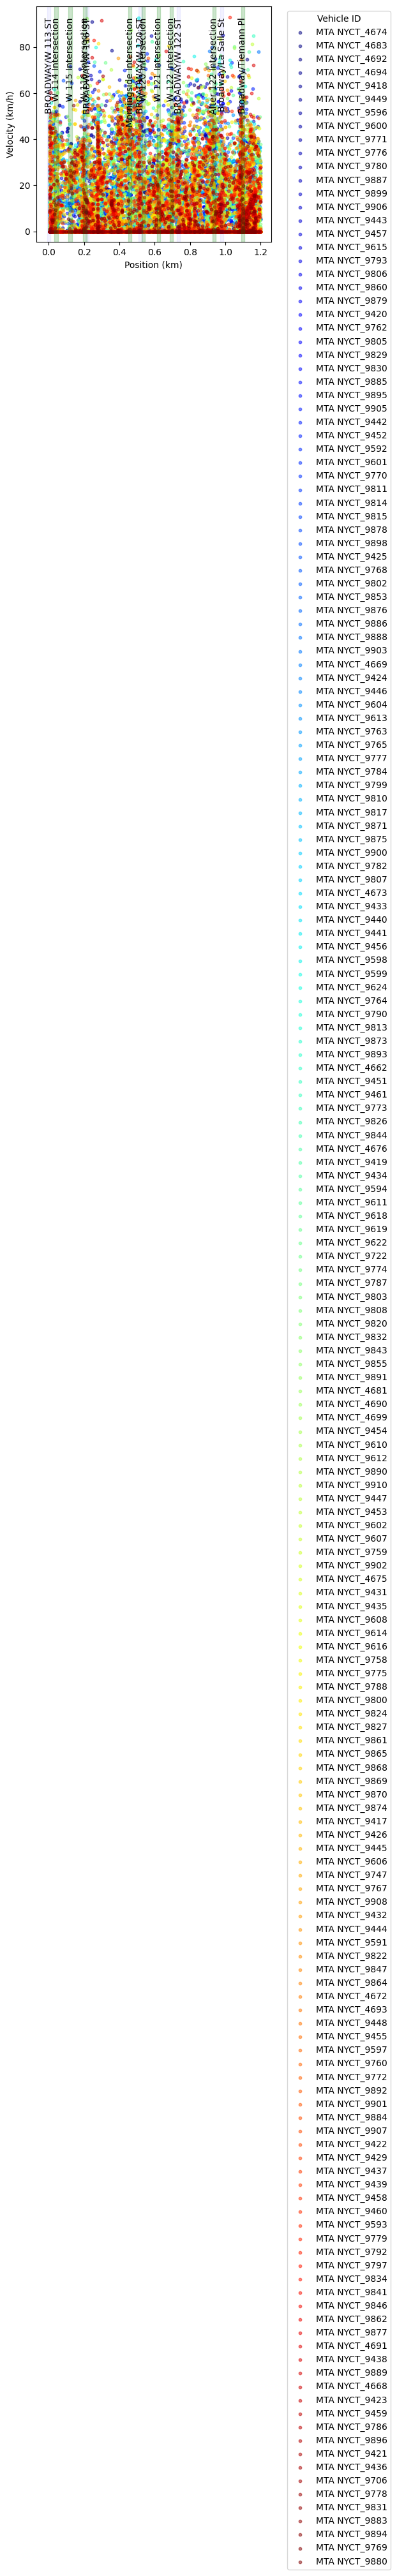

In [3]:
#Trending Graph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate haversine distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

#113 Bus Stop
#ref_lat=40.806258
#ref_lon=-73.964954

#Intersection before 113 Bus Stop
ref_lat=40.806258
ref_lon=-73.964954

stops_list = [
    {"stop_name": "BROADWAY/W 113 ST", "stop_id": "404260", "lat": 40.806258, "lon": -73.964954},
    {"stop_name": "BROADWAY/W 116 ST", "stop_id": "403122", "lat": 40.807990, "lon": -73.963751},
    {"stop_name": "BROADWAY/W 120 ST", "stop_id": "404262", "lat": 40.810341, "lon": -73.961983},
    {"stop_name": "BROADWAY/W 122 ST", "stop_id": "403125", "lat": 40.812034, "lon": -73.960739},
    {"stop_name": "Broadway/La Salle St", "stop_id": "403126", "lat": 40.813986, "lon": -73.959347},

]


intersection_list=[
    {"intersection_name": "W 114 Intersection", "lat": 40.806599, "lon": -73.964758},
    {"intersection_name": "W 115 Intersection", "lat": 40.807238, "lon": -73.964326},
    {"intersection_name": "W 116 Intersection", "lat": 40.807893, "lon": -73.963817},
    {"intersection_name": "W 120 Intersection", "lat": 40.810504, "lon": -73.961941},
    {"intersection_name": "W 122 Intersection", "lat": 40.811741, "lon": -73.961013},
    {"intersection_name": "Morningside Intersection", "lat": 40.809908, "lon": -73.962372},
    {"intersection_name": "W 121 Intersection", "lat": 40.811161, "lon": -73.961409},
    {"intersection_name": "After 122 Intersection", "lat": 40.813647, "lon": -73.959615},
    {"intersection_name": "Broadway/Tiemann Pl", "lat": 40.814921, "lon": -73.958662}
]

stops_df = pd.DataFrame(stops_list)
intersection_df=pd.DataFrame(intersection_list)

def calculate_position1(row, ref_lat, ref_lon):
    distance = haversine(ref_lat, ref_lon, row['lat'], row['lon'])
    return distance
def calculate_position2(row, ref_lat, ref_lon):
    distance = haversine(ref_lat, ref_lon, row['Latitude'], row['Longitude'])
    return distance

stops_df['position'] = stops_df.apply(lambda row: calculate_position1(row, ref_lat, ref_lon), axis=1)
intersection_df['position'] = intersection_df.apply(lambda row: calculate_position1(row, ref_lat, ref_lon), axis=1)
df['position'] = df.apply(lambda row: calculate_position2(row, ref_lat, ref_lon), axis=1)
df = df[df['position'] < 1.2]
stops_df = stops_df[stops_df['position'] < 1.2]
intersection_df = intersection_df[intersection_df['position'] < 1.2]

fig, ax = plt.subplots()
unique_vids = df['VehicleRef'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_vids)))
vid_to_color = dict(zip(unique_vids, colors))
for vid, color in vid_to_color.items():
    df_vid = df[df['VehicleRef'] == vid]
    ax.scatter(df_vid['position'], df_vid['velocity_kmh'], alpha=0.5, s=10, color=color, label=str(vid))
for _, stop in stops_df.iterrows():
    ax.axvspan(stop['position'] - 0.01, stop['position'] + 0.01, color='blue', alpha=0.05)
    ax.text(stop['position'], ax.get_ylim()[1] * 0.95, stop['stop_name'], rotation=90, verticalalignment='top', horizontalalignment='center', fontsize=10, color='black')
for _, stop in intersection_df.iterrows():
    ax.axvspan(stop['position'] - 0.01, stop['position'] + 0.01, color='green', alpha=0.2)
    ax.text(stop['position'], ax.get_ylim()[1] * 0.95, stop['intersection_name'], rotation=90, verticalalignment='top', horizontalalignment='center', fontsize=10, color='black')


ax.set_xlabel('Position (km)')
ax.set_ylabel('Velocity (km/h)')

plt.subplots_adjust(right=0.7)
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


After visualizing the bus moving trends, select the "After 122 Intersection" as the desired intersection to consider. Hence chose a few intersections near this chosen intersection to better visualize the distance and velocity changes trend.

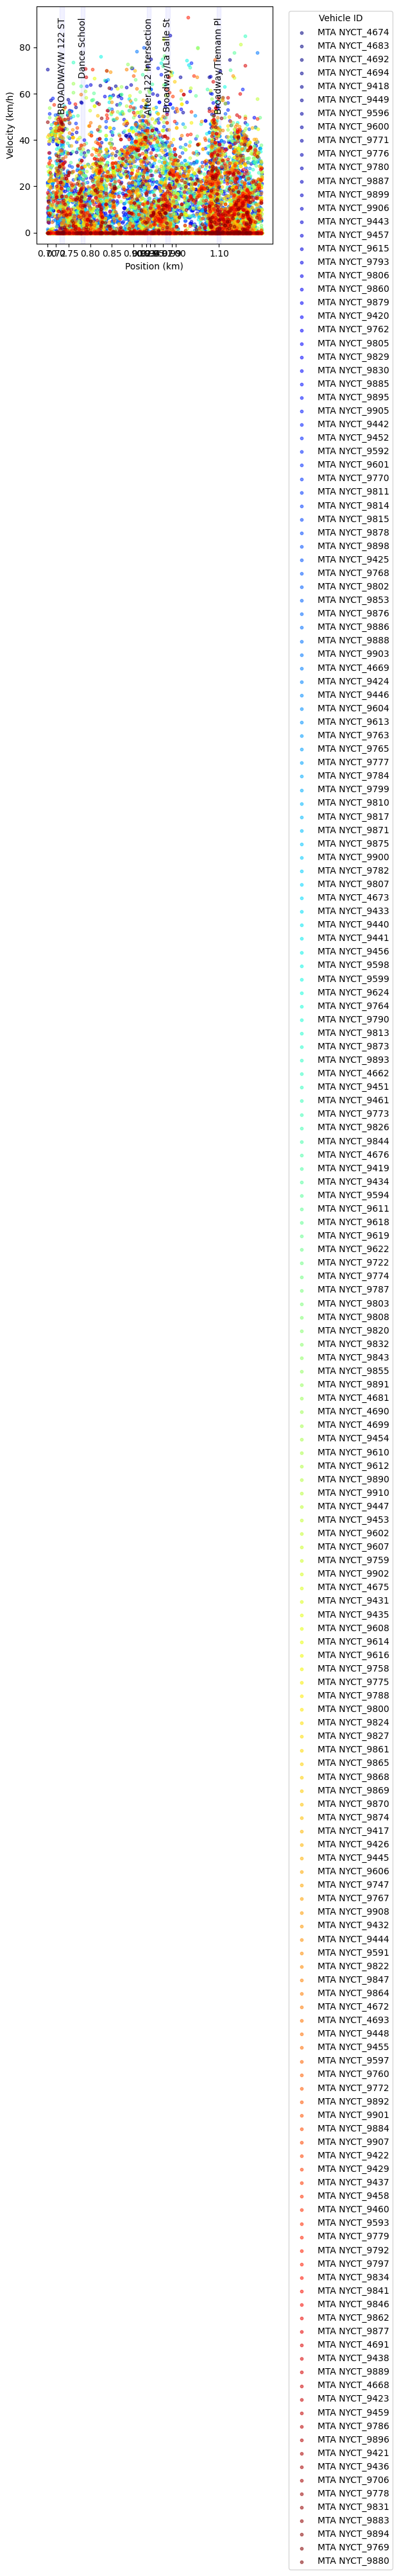

In [4]:
# @title Intersection Example Graph
specific_stop=[
    {"name": "After 122 Intersection", "lat": 40.813647, "lon": -73.959615},
    {"name": "BROADWAY/W 122 ST", "lat": 40.812034, "lon": -73.960739},
    {'name': 'Dance School','lat':40.812413,'lon':-73.960443},
    {"name": "Broadway/La Salle St", "lat": 40.813986, "lon": -73.959347},
    {"name": "Broadway/Tiemann Pl", "lat": 40.814921, "lon": -73.958662}
]

specific_df = pd.DataFrame(specific_stop)

specific_df['position'] = specific_df.apply(lambda row: calculate_position1(row, ref_lat, ref_lon), axis=1)

specific=df

specific['position_specific'] = specific.apply(lambda row: calculate_position2(row, ref_lat, ref_lon), axis=1)
specific = specific[(specific['position_specific'] < 1.2) & (specific['position_specific'] > 0.7)]
specific_df = specific_df[(specific_df['position'] < 1.2) &(specific_df['position']>0.7)]

fig, ax = plt.subplots()
unique_vids = specific['VehicleRef'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_vids)))
vid_to_color = dict(zip(unique_vids, colors))
for vid, color in vid_to_color.items():
    df_vid = specific[specific['VehicleRef'] == vid]
    ax.scatter(df_vid['position_specific'], df_vid['velocity_kmh'], alpha=0.5, s=10, color=color, label=str(vid))
for _, stop in specific_df.iterrows():
    ax.axvspan(stop['position'] - 0.005, stop['position'] + 0.005, color='blue', alpha=0.05)
    ax.text(stop['position'], ax.get_ylim()[1] * 0.95, stop['name'], rotation=90, verticalalignment='top', horizontalalignment='center', fontsize=10, color='black')
ax.set_xlabel('Position (km)')
ax.set_ylabel('Velocity (km/h)')

plt.subplots_adjust(right=0.7)
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([0.7,0.72,0.75,0.8,0.85,0.9,0.92,0.93,0.94,0.95,0.97,0.99,1.0,1.1])
plt.show()

**RECONSTRUCTING BUS KINEMATICS FROM SPARSE DATA**

We would like to estimate if a bus was stopped at an intersection, how long it was stopped, and at what time it left the intersection.

However, because the update points for each bus are sporadic, we need to approximate a bus trajectory between each two update points.

*Step 1:* For "After 122 Intersection", select bus passes that have updates within a given interval before and after this intersection. From the previous trend visualization graph, I chose the before interval from 0.79 to 0.91 km and the after interval from 0.945 to 0.975 km.

*Step 2:* To determine if a bus stopped at an intersection, approximate the intersection delay, td (Equation(1)), by subtracting projected travel time from actual travel time.

td=(t2-t1)/((x2-x1)/((v1+v2)/2)), where x1, v1, and t1 denote the position, velocity, and time stamp of the last update of a bus before an intersection of interest, and x2, v2, and t2 are the position, velocity, and time stamp of the first update of that bus after the intersection.

In [5]:
# @title Equation (1) - td
###STEP 1

before_intersection_interval = (0.79, 0.91)
after_intersection_interval = (0.945, 0.975)
before_intersection_passes = df[(df['position'] >= before_intersection_interval[0]) & (df['position'] <= before_intersection_interval[1])]
after_intersection_passes = df[(df['position'] >= after_intersection_interval[0]) & (df['position'] <= after_intersection_interval[1])]

bus_passes_near_intersection = pd.concat([before_intersection_passes, after_intersection_passes])
#filtered out also passes with low velocity (less than 3 km/h)
bus_passes_near_intersection = bus_passes_near_intersection[bus_passes_near_intersection['velocity_kmh'] >= 2]

###STEP 2
bus_passes_near_intersection['ResponseTimestamp'] = pd.to_datetime(bus_passes_near_intersection['ResponseTimestamp'], format='ISO8601')
bus_passes_near_intersection.sort_values(by=['VehicleRef', 'ResponseTimestamp'], inplace=True)

def calculate_td(group):
    before = group[(group['position'] >= before_intersection_interval[0]) & (group['position'] <= before_intersection_interval[1])]
    after = group[(group['position'] >= after_intersection_interval[0]) & (group['position'] <= after_intersection_interval[1])]

    if before.empty or after.empty:
      return None

    before = before.iloc[-1]
    after = after.iloc[0]
    t1 = before['ResponseTimestamp']
    t2 = after['ResponseTimestamp']
    x1 = before['position']
    x2 = after['position']
    v1 = before['velocity_kmh']
    v2 = after['velocity_kmh']
    td = ((t2 - t1).total_seconds()/3600) - ((x2 - x1) / ((v1 + v2) / 2))
    return td

td_values = bus_passes_near_intersection.groupby('VehicleRef').apply(calculate_td)
bus_passes_near_intersection['td'] = bus_passes_near_intersection['VehicleRef'].map(td_values)

We pick the data with td>0 to ensure that the bus has a delay, which means that it does not pass the intersection with a green interval.

At this point, I also draw the velocity changes plot for all buses passing the chosen intersection (before and after) and try to give a brief visualization of acceleration and deceleration (This does not provide pivotal information about the calculation later).

<ipython-input-6-766d197abfa1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_td_df['velocity_mps'] = (positive_td_df['velocity_kmh'] * 1000) / 3600


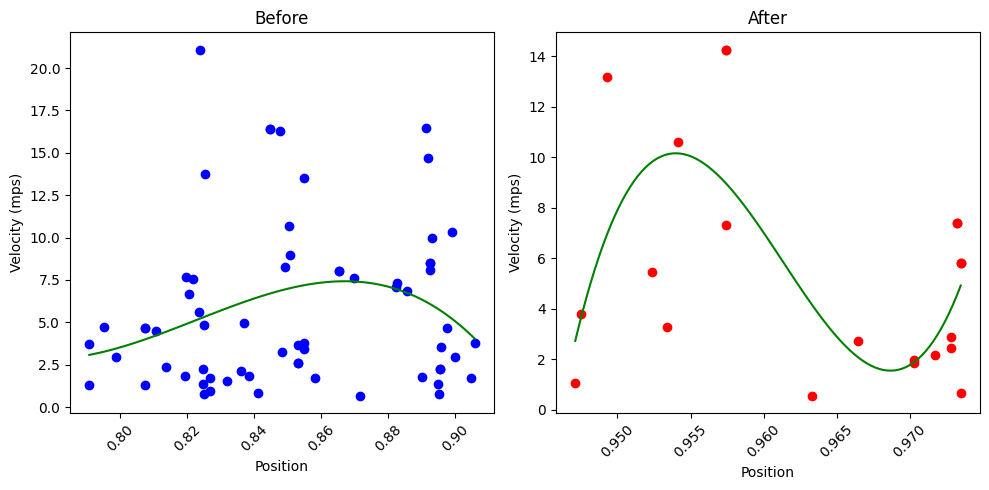

In [6]:
# @title Estimate acceleraion and deceleration
###STEP 3 ##all buses
#multiple routes
positive_td_df = bus_passes_near_intersection[bus_passes_near_intersection['td'] > 0]
positive_td_df['velocity_mps'] = (positive_td_df['velocity_kmh'] * 1000) / 3600

before_3 = positive_td_df[(positive_td_df['position'] >= before_intersection_interval[0]) & (positive_td_df['position'] <= before_intersection_interval[1])]
after_3 = positive_td_df[(positive_td_df['position'] >= after_intersection_interval[0]) & (positive_td_df['position'] <= after_intersection_interval[1])]

degree = 3
coefficients_before = np.polyfit(before_3['position'], before_3['velocity_mps'], degree)
polynomial_before = np.poly1d(coefficients_before)
positions_poly_before = np.linspace(before_3['position'].min(), before_3['position'].max(), 100)
regression_line_before = polynomial_before(positions_poly_before)

coefficients_after = np.polyfit(after_3['position'], after_3['velocity_mps'], degree)
polynomial_after = np.poly1d(coefficients_after)
positions_poly_after = np.linspace(after_3['position'].min(), after_3['position'].max(), 100)
regression_line_after = polynomial_after(positions_poly_after)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(before_3['position'], before_3['velocity_mps'], color='blue')
axs[0].plot(positions_poly_before, regression_line_before, color='green')
axs[0].set_title('Before')
axs[0].set_xlabel('Position')
axs[0].set_ylabel('Velocity (mps)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].scatter(after_3['position'], after_3['velocity_mps'], color='red')
axs[1].plot(positions_poly_after, regression_line_after, color='green')
axs[1].set_title('After')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('Velocity (mps)')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Filter the previous data into a simplier version containing "VehicleRef", "ResponseTimestamp", "position", "Velocity_mps", and "td". (Now the velocity is in meter per second)

In [7]:
positive_td_df=positive_td_df[['VehicleRef', 'ResponseTimestamp', 'position','velocity_mps', 'td']]
#positive_td_df

This is new filtered data that will later be used to calculate Equations (14) and (15).

In [8]:
green=positive_td_df[positive_td_df['td']<0.1]

Since the whole data in collected for many times at many days, buses with the same name can pass through the intersection several times in one day. For example, the bus with VehicleRef "MTA NYCT_4693" can pass this intersection at 9 am and also at 2 pm.

Then I use "RoundTimestamp" to normalize the selected data, setting that the time for one bus traveling past this intersection is within 10 minutes. Now the new data will have information about each bus passing the intersection multiple times.

In [9]:
# @title "Normalize" Time for each bus
#Equation (2) (3), t_stop & t_start
#Set a mask to separate bus travelling time
positive_td_df['Date'] = positive_td_df['ResponseTimestamp'].dt.date
positive_td_df['RoundedTimestamp'] = positive_td_df['ResponseTimestamp'].dt.round('10min')
interval_stats = positive_td_df.groupby(['VehicleRef', 'Date', 'RoundedTimestamp']).agg(
    min_timestamp=('ResponseTimestamp', 'min'),
    max_timestamp=('ResponseTimestamp', 'max')
).reset_index()

# Calculate the duration within each 10-minute interval
interval_stats['Duration'] = (interval_stats['max_timestamp'] - interval_stats['min_timestamp'])

*Step 3:* We approximate that the bus moves with a constant velocity v1, then comes to a stop at the intersection at a constant deceleration a_dec, and then at the start of green it accelerates with constant acceleration a_acc to a constant velocity v2. We estimate the time the bus comes to a stop t_stop and the time the bus leaves the intersection t_start.

t_stop=t1+(d1/v1)+v1/(2*a_dec) (Equation(2))

t_start=t2-(d2/v2)-v2/(2*a_acc) (Equation(3))

d1=x_signal-x1, and d2=x2-x_signal, where x_signal is the location of the light.

Since we x_signal is known, d1 and d2 here are the distance of the bus passing before the intersection and the distance of the bus passing after the intersection.

I set up the a_dec=-1.5 m/s^2 and a_acc=1 m/s^2 as approximation.


In [10]:
# @title Equation (2)(3)
a_dec=abs(-1.5)
a_acc=1

def calculate_stop_start_times(row, a_dec, a_acc):
    d1 = (before_intersection_interval[1] - before_intersection_interval[0]) * 1000
    d2 = (after_intersection_interval[1] - after_intersection_interval[0]) * 1000

    v1=before_3['velocity_mps'].mean()
    v2=after_3['velocity_mps'].mean()

    t_stop_seconds = d1 / v1 + v1 / (2 * a_dec)
    t_start_seconds = d2 / v2 + v2 / (2 * a_acc)

    t_stop = row['min_timestamp'] + pd.to_timedelta(t_stop_seconds, unit='s')
    t_start = row['max_timestamp'] - pd.to_timedelta(t_start_seconds, unit='s')

    return t_stop, t_start

interval_stats[['t_stop', 't_start']] = interval_stats.apply(
    lambda row: calculate_stop_start_times(
        row, a_dec, a_acc),axis=1,result_type="expand")

#interval_stats

We accept the data only when t_stop<=t_start and estimate that the bus came to a full stop at a red light.

The duration of red “observed” by a particular bus is then estimated as:
t_red=t_start-t_stop+(v1/a_dec) (Equation(4))

Aggregating trends for a sufficiently large number of bus passes will later lead to an estimate of total red duration of a phase.

In the above calculations, we assumed that acceleration and deceleration of buses were known and constants.

In [11]:
# @title Equation (4)
#Equation (4)
valid_passes = interval_stats[interval_stats['t_stop'] <= interval_stats['t_start']]

def calculate_red_duration(row, a_dec):
    v1=before_3['velocity_mps'].mean()
    a_dec=abs(-1.5)

    time_to_stop = v1 / a_dec

    t_red_seconds = (row['t_start'] - row['t_stop']).total_seconds() + time_to_stop

    return t_red_seconds

valid_passes['t_red'] = valid_passes.apply(calculate_red_duration, axis=1, a_dec=a_dec)
#valid_passes

<ipython-input-11-66f1a0db10b1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_passes['t_red'] = valid_passes.apply(calculate_red_duration, axis=1, a_dec=a_dec)


**CROWD-SOURCING ACCELERATION AND DECELERATION OF BUSES**

By giving enough bus data, and treating the accelerations and velocity as constant, we can estimate the bus accelerations before and after the intersections. Hence the velocity while accelerating from a stop at a signal can be related to the distance traveled as follows:

v^2(x)=2*a_acc*(x-x_signal) (Equation (5)),

where now a_acc is the average acceleration estimated from the data.

Defining y=x-x_signal, ψ=v^2(x), θ=1/(2*a_acc):

y=θψ (Equation(6))

However, since the data in my calculation is limited, I still set up the acceleration=1 m/s^2 and deceleration=1.5 m/s^2.
But I can instead approximate d1=x1-x_signal and d2=x2-x_signal using Equation (5).

After getting the new d1 and d2, I can redo the Equations (2)(3)(4) to find the new duration of red “observed” by a particular bus.

In [12]:
# @title Equation (5)(6) -Estimate x-x_signal and redo equation (2)(3)(4)
#Estimating the acceleration and deceleration

#v1^2=2*a_acc(x1-x_signal) / v2^2=2*a_dec(x2-x_signal)
#y=θψ; ψ=v^2, θ=1/a_acc, y=x1-x_signal

a_dec=abs(-1.5)
a_acc=1

def estimate_y(velocity, a):
    y = (velocity ** 2) / (a)
    return y

v1 = before_3['velocity_mps'].mean()
y_before = estimate_y(v1, a_acc)

v2 = after_3['velocity_mps'].mean()
y_after = estimate_y(v2, a_dec)


def calculate_stop_start_times_new(row, a_dec, a_acc):
    d1 = y_before
    d2 = y_after

    v1=before_3['velocity_mps'].mean()
    v2=after_3['velocity_mps'].mean()

    t_stop_seconds = d1 / v1 + v1 / (2 * a_dec)
    t_start_seconds = d2 / v2 + v2 / (2 * a_acc)

    t_stop_new = row['min_timestamp'] + pd.to_timedelta(t_stop_seconds, unit='s')
    t_start_new = row['max_timestamp'] - pd.to_timedelta(t_start_seconds, unit='s')

    return t_stop_new, t_start_new

def calculate_red_duration_new(row, a_dec):
    v1=before_3['velocity_mps'].mean()
    a_dec=abs(-1.5)

    time_to_stop = v1 / a_dec

    t_red_seconds_new = (row['t_start_new'] - row['t_stop_new']).total_seconds() + time_to_stop

    return t_red_seconds_new


interval_stats[['t_stop_new', 't_start_new']] = interval_stats.apply(
    lambda row: calculate_stop_start_times_new(
        row, a_dec, a_acc),axis=1,result_type="expand")

#Comparison
valid_passes = interval_stats[interval_stats['t_stop_new'] <= interval_stats['t_start_new']]
valid_passes['t_red'] = valid_passes.apply(calculate_red_duration, axis=1, a_dec=a_dec)
valid_passes['t_red_new'] = valid_passes.apply(calculate_red_duration_new, axis=1, a_dec=a_dec)
#valid_passes

<ipython-input-12-2ceedddeacc3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_passes['t_red'] = valid_passes.apply(calculate_red_duration, axis=1, a_dec=a_dec)
<ipython-input-12-2ceedddeacc3>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_passes['t_red_new'] = valid_passes.apply(calculate_red_duration_new, axis=1, a_dec=a_dec)


Filter the data by the appropriate duration of red “observed” by a particular bus, which is less than 100 seconds.

In [13]:
#New t_red (red phase)
new_valid_passes=valid_passes[['VehicleRef','Date','RoundedTimestamp','Duration','t_stop_new','t_start_new','t_red_new']]
new_valid_passes=new_valid_passes[new_valid_passes['t_red_new']<100]
#new_valid_passes

Visualize the distribution of the new calculated duration of red.

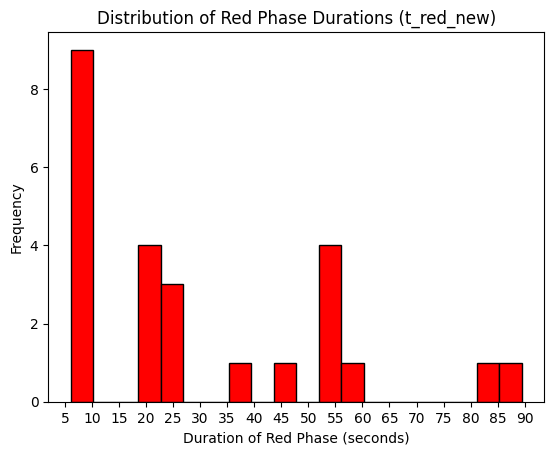

In [14]:
#Distribution of calculated red phase
plt.hist(new_valid_passes['t_red_new'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Red Phase Durations (t_red_new)')
plt.xlabel('Duration of Red Phase (seconds)')
plt.ylabel('Frequency')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
plt.show()

Just for comparison, this data contains the old duration of red and the visualizations of the distributions of the old duration of red.

(The new red phase looks better so we still use the new equation for further calculation.)

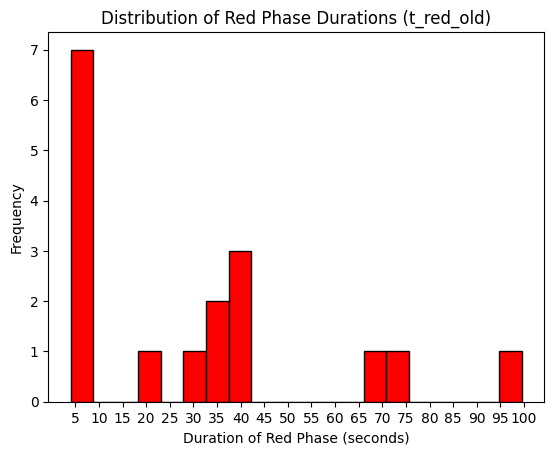

In [15]:
#Old t_red (red phase)
old_valid_passes=valid_passes[['VehicleRef','Date','RoundedTimestamp','Duration','t_stop','t_start','t_red']]
old_valid_passes = old_valid_passes[(old_valid_passes['t_red'] < 100) & (old_valid_passes['t_red'] > 0)]
old_valid_passes

plt.hist(old_valid_passes['t_red'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Red Phase Durations (t_red_old)')
plt.xlabel('Duration of Red Phase (seconds)')
plt.ylabel('Frequency')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,95,100])
plt.show()

**Estimating Cycle Times**

For fixed-time signals with phases that repeat cyclically, the time between the start of greens of a phase must be an integer multiple of the cycle time. The difference between two consecutive approximations of the start of greens, based on bus movements, then must be an “almost” integer multiple of the cycle time.

Let's denote b_g is the time between approximated start of greens.

*b_g(j)=t_start(j+1)-t_start(j) (Equation7)*

For a given cycle time C, we can then calculate the remainder of the division of b_g and C:

*modC(b_g)=b_g-round(b_g/C)C (Equation(8))*

We expect the modC(b_g) to be close to 0 on average, hence we can approximate the C by solving the optimization problem:

*C_average=argmin_C sum from j=1 to n (modC(b_g(j))/(C/2))^2 (Equation (9))*

In [16]:
# @title Equation (7)(8)(9) - cycle time
from scipy.optimize import differential_evolution

new_valid_passes['t_start_new'] = pd.to_datetime(new_valid_passes['t_start_new'])
sorted_df = new_valid_passes.sort_values('t_start_new')

#Equation (7)
sorted_df['time_to_next_bus_start'] = sorted_df['t_start_new'].diff().shift(-1).dt.total_seconds()
sorted_df.dropna(inplace=True)

#Equation (8)
def custom_mod(value, cycle_time):
    nearest_multiple = np.round(value / cycle_time) * cycle_time
    mod_value = value - nearest_multiple
    return mod_value

# Equation (9)
def cost_function(C, b_g_values):
    normalized_mods = [custom_mod(b_g, C[0]) for b_g in b_g_values]
    sum_of_squares = np.sum(np.square(normalized_mods) / (C[0] / 2)**2)
    return sum_of_squares

#Optimization
np.random.seed(48)
bounds = [(1, 120)]
result = differential_evolution(cost_function, bounds=bounds, args=(sorted_df['time_to_next_bus_start'].values,),seed=48)
C_estimated = result.x[0] if result.success else None
print(f'Estimated cycle time C: {C_estimated} seconds')

sorted_df['mod_cycle_time'] = sorted_df['time_to_next_bus_start'].apply(lambda x: custom_mod(x, C_estimated))
mean_mod_cycle_time = (sorted_df['mod_cycle_time']).mean()
print(f'Mean of mod_cycle_time: {mean_mod_cycle_time}')

Estimated cycle time C: 70.54389616453612 seconds
Mean of mod_cycle_time: -0.9986892720225397


The estimation of the cycle time is around 71 seconds.

Below is the distribution for mod_cycle_time, and the desirable distribution is normal.

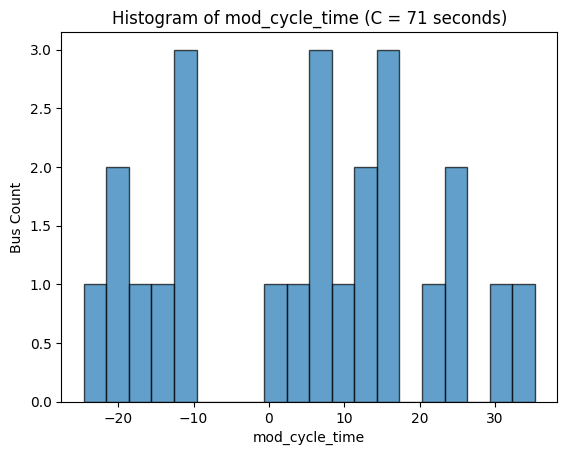

In [17]:
import matplotlib.pyplot as plt

C_estimated=round(C_estimated)
sorted_df['mod_cycle_time'] = sorted_df['time_to_next_bus_start'].apply(lambda x: custom_mod(x, C_estimated))

plt.hist(sorted_df['mod_cycle_time'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('mod_cycle_time')
plt.ylabel('Bus Count')
plt.title(f'Histogram of mod_cycle_time (C = {C_estimated} seconds)')
plt.show()

**ESTIMATING START OF GREENS**

We propose to continuously estimate the start of a green phase based on the movement of buses that accelerate from a stop at an intersection by using Equation (3). Because of C- periodicity of a fixed-time light within each schedule, we can map the latest estimates of start of green to a single reference interval [−C/2, C/2] by applying the modC operator.

For the ith qualifying bus pass: *t_i=modC(t_start(i)) (Equation(10))*

We can then create an average estimate of the start of green in this reference interval. The periodicity can be better visualized if the time axis is wrapped onto a circle. Each
start of green can then be represented by a vector with angle θi=(2*pi/C)*ti on the circle.

Then we can calculate the average θ (Equation (11)), and the average start of green is obtained by mapping back, the average angle to the time axis (Equation (12)), as well as the variance of this estimate is then obtained based on the minimum cyclic distance to the average (Equation (13)).

In [18]:
# @title Equation (10)(11)(12)(13)

def custom_mod_new(value, cycle_time):
    nearest_multiple = np.round(value / cycle_time) * cycle_time
    mod_value = value - nearest_multiple
    # Normalize the mod_value into the range [-C/2, C/2]
    normalized_mod_value = ((mod_value + cycle_time / 2) % cycle_time) - cycle_time / 2
    return normalized_mod_value

# Equation (10)
sorted_df['ti']=sorted_df['time_to_next_bus_start'].apply(lambda x: custom_mod_new(x,C_estimated))

sorted_df['theta_i'] = (2 * np.pi * sorted_df['ti']) / C_estimated
sin_components = np.sin(sorted_df['theta_i'])
cos_components = np.cos(sorted_df['theta_i'])

# Equation (11) - average angle
average_angle = np.arctan2(sin_components.sum(), cos_components.sum())

# Equation (12) - average start of green
k=0
average_start_of_green = (C_estimated * average_angle) / (2 * np.pi)+ k * C_estimated

def cyclic_variance(ti_values, average_t_sog, cycle_time):
    squared_distances = [(custom_mod_new(ti - average_t_sog, cycle_time))**2 for ti in ti_values]
    variance = sum(squared_distances) / len(squared_distances)
    return variance

# Equation (13) - variance start of green
variance_t_sog = cyclic_variance(sorted_df['ti'].values, average_start_of_green, C_estimated)

print('Equation(11) the average angle',average_angle)
print('Equation(12) The average start of the green:',average_start_of_green)
print('Equation(13) variance of estimation:',variance_t_sog)

Equation(11) the average angle 0.7151238884927552
Equation(12) The average start of the green: 8.080900626147075
Equation(13) variance of estimation: 300.55427033699453


**DIRECT ESTIMATION OF GREEN INTERVALS AND PROBABILITY OF GREEN**

It is possible to interpolate a point in time that a phase was green based on the bus data before and after an intersection.

Now we want the data with traffic delay td (Equation (1)) equal to 0. However, since our data is limited, I choose the td<(0.1), which is close enough to show a tiny traffic delay.

Interpolate between update times t1 and t2 to
determine the point in time at which the signal was green. For constant acceleration a=(v2-v1)/(t2-t1), we have:

*x_signal=x1+v1(t_g-t1)+(1/2)a(t_g-t1)^2 (Equation(14))*

Here t_g denotes a time at which the signal was green which is the feasible solution to the above quadratic equation:

*t_g=t1+(-v1+sqrt(v1^2+2a(x_signal-x1))/a) (Equation(15))*

Ideally, we would like to aggregate all point calculations of tg to estimate intervals of green. For signals with fixed and known cycle time C, this can be done by mapping all values of tg onto a reference interval [0, C].

In [19]:
# @title Equation (15)(14)
#td<0.1
import math
before_green = green[(green['position'] >= before_intersection_interval[0]) & (green['position'] <= before_intersection_interval[1])]
after_green = green[(green['position'] >= after_intersection_interval[0]) & (green['position'] <= after_intersection_interval[1])]
#'Normalize'
green['Date'] = green['ResponseTimestamp'].dt.date
green['RoundedTimestamp'] = green['ResponseTimestamp'].dt.round('10min')
green_stats = green.groupby(['VehicleRef', 'Date', 'RoundedTimestamp']).agg(
    min_timestamp=('ResponseTimestamp', 'min'),
    max_timestamp=('ResponseTimestamp', 'max'),
).reset_index()
green_stats['Duration'] = (green_stats['max_timestamp'] - green_stats['min_timestamp'])

v1_green = before_green['velocity_mps'].mean()
v2_green = after_green['velocity_mps'].mean()
distance=(before_intersection_interval[1] - before_intersection_interval[0]) * 1000

#constance acceleration
a=(v2_green-v1_green)/(green_stats['Duration'].mean().total_seconds())

#Equation (15)
#b=tg-t1
b=(-v1_green+math.sqrt(v1_green**2+2*a*distance))/a
green_stats['t1']=pd.to_datetime(green_stats['min_timestamp'])
green_stats['tg'] = green_stats['t1'] + pd.to_timedelta(b, unit='s')
green_stats['tg_seconds'] = (green_stats['tg'] - green_stats['tg'].dt.normalize()).dt.total_seconds()
green_stats['tg_mapped'] = green_stats['tg_seconds'] % C_estimated
#green_stats

<ipython-input-19-05c754ea0bbd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  green['Date'] = green['ResponseTimestamp'].dt.date
<ipython-input-19-05c754ea0bbd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  green['RoundedTimestamp'] = green['ResponseTimestamp'].dt.round('10min')


This is the plot whoing green times mapped to one cycle interval (C=71 seconds).

When mapping all green times to a single interval, we have accounted for known changes in the signal schedule. The second subplot is a histogram highlighting the concentration of points.

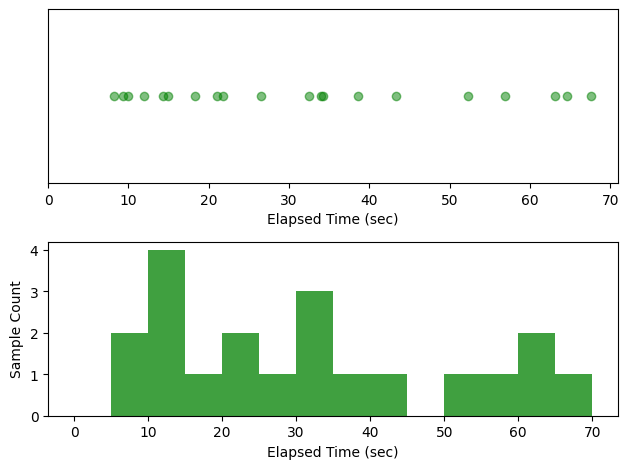

In [20]:
#estimate the intervals of green
plt.subplot(2, 1, 1)
plt.scatter(green_stats['tg_mapped'], [1] * len(green_stats['tg_mapped']), alpha=0.5, color='green')
plt.ylim(0.5, 1.5)
plt.xlim(0, 71)
plt.yticks([])
plt.xlabel('Elapsed Time (sec)')

plt.subplot(2, 1, 2)
plt.hist(green_stats['tg_mapped'], bins=range(0, 71, 5), alpha=0.75, color='green')
plt.xlabel('Elapsed Time (sec)')
plt.ylabel('Sample Count')

plt.tight_layout()
plt.show()

Below is the information about comparing the estimated and actual cycle time, red and green phases. I averaged all red and green phase estimations for each bus to finalize the result.

Since our data is limited, the estimation does not provide an excellent performance, but I think the result is convincible and useful.

In [29]:
# @title Compare with Actual Data
print("The estimated cycle time is",C_estimated,"seconds")
print("The actual cycle time at intersection 'After 122 Intersection' is about 90 seconds\n")

Estimated_red_phase=new_valid_passes['t_red_new'].mean()
Estimated_green_phase=green_stats['tg_mapped'].mean()
print('The actual green phase is 40 seconds, yellow phase is 3 seconds, and red phase is 47 seconds')
print('The estimated red phase is',Estimated_red_phase,'seconds')
print('The estimated green phase is',Estimated_green_phase,'seconds')

The estimated cycle time is 71 seconds
The actual cycle time at intersection 'After 122 Intersection' is about 90 seconds

The actual green phase is 40 seconds, yellow phase is 3 seconds, and red phase is 47 seconds
The estimated red phase is 30.18431358621396 seconds
The estimated green phase is 32.17089716599912 seconds
